In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def objective_function(x):
    return (x[0] - 4)**2 + (x[1] - 2)**2

In [40]:
def constraints(x):
    return [
        x[0] + x[1] - 3,  # x[0] + x[1] <= 3
        x[0] + 2*x[1] - 4,  # x[0] + 2*x[1] <= 4
        -x[0],            # x[0] >= 0
        -x[1]             # x[1] >= 0
    ]

In [41]:
def is_feasible(x):
    return all(c <= 0 for c in constraints(x))

In [55]:
def gradient(x):
    epsilon = 1e-8
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_forward = x.copy()
        x_backward = x.copy()
        x_forward[i] += epsilon
        x_backward[i] -= epsilon
        grad[i] = (objective_function(x_forward) - objective_function(x_backward)) / (2 * epsilon)
    return grad

In [56]:
def projection_direction(x, grad):
    cons = constraints(x)
    if all(c <= 0 for c in cons):
        return -grad / np.linalg.norm(grad)  # Двигаемся по антиградиенту

    p = -grad.copy()
    for i, c in enumerate(cons):
        if c > 0:
            p += np.array([1 if j == i else 0 for j in range(len(x))]) * -c
    return p / np.linalg.norm(p)

In [62]:
def feasible_directions(x0, alpha=0.5, tol=1e-5, max_iter=100):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    alphas = []
    ps = []

    for _ in range(max_iter):
        grad = gradient(x)
        p = projection_direction(x, grad)

        if np.linalg.norm(p) < tol:
            print("Optimization converged.")
            break

        while True:
            x_new = x + alpha * p

            if is_feasible(x_new):
                break
            alpha *= 0.5

        x = x_new
        history.append(x.copy())
        alphas.append(alpha)
        ps.append(p.copy())

        if np.linalg.norm(grad) < tol:
            print("Gradient close to zero. Optimization converged.")
            break

    return x, history, alphas, ps

In [71]:
def project_to_constraints(x, p, tol=1e-5):
    """
    Проекция точки x с шагом p на множество ограничений.
    Если ограничения нарушены, корректируем точку так, чтобы она стала допустимой.
    """
    x_new = x + p
    constraints_vals = constraints(x_new)

    # Для каждого ограничения проверяем, нарушено ли оно
    for i, constraint_val in enumerate(constraints_vals):
        if constraint_val > tol:  # Если ограничение нарушено
            # Корректируем точку, чтобы оно стало на границе этого ограничения
            # Мы не знаем, как конкретно должно происходить исправление, так как ограничения могут быть произвольными.
            # Однако мы корректируем точку так, чтобы значение ограничения становилось <= 0.
            
            # Это простейший способ исправить, если g(x) > 0:
            # Мы будем просто уменьшать x, чтобы g(x) стало <= 0.
            # Однако для более сложных ограничений потребуется более сложная логика.
            
            if isinstance(constraint_val, float) or isinstance(constraint_val, int):
                # Пример исправления для линейных ограничений
                x_new -= (constraint_val / np.linalg.norm(p)) * p  # корригируем по направлению p
            else:
                pass  # Здесь можно добавить другие способы коррекции, если нужно
            
    return x_new - x  # Возвращаем корректированный шаг

def feasible_directions(x0, alpha=0.5, tol=1e-5, max_iter=100):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    alphas = []
    ps = []

    for _ in range(max_iter):
        grad = gradient(x)
        p = projection_direction(x, grad)  # Вычисление направления проекции

        # Проекция на ограничения
        p_projected = project_to_constraints(x, p)

        if np.linalg.norm(p_projected) < tol:
            print("Optimization converged.")
            break

        while True:
            x_new = x + alpha * p_projected  # Двигаемся по проекции на ограничения

            if is_feasible(x_new):
                break
            alpha *= 0.5

        x = x_new
        history.append(x.copy())
        alphas.append(alpha)
        ps.append(p_projected.copy())

        if np.linalg.norm(grad) < tol:
            print("Gradient close to zero. Optimization converged.")
            break

    return x, history, alphas, ps

In [72]:
def visualize(history, alphas, ps):
    history = np.array(history)

    # Ограничения
    x = np.linspace(-1, 5, 400)
    y = np.linspace(-1, 5, 400)
    X, Y = np.meshgrid(x, y)
    Z = objective_function([X, Y])

    plt.figure(figsize=(10, 6))
    plt.contour(X, Y, Z, levels=50, cmap="viridis")

    # Область допустимых решений
    for i, constraint in enumerate(constraints([X, Y])):
        plt.contourf(X, Y, constraint > 0, alpha=0.1, cmap="Reds")
    
    # История точек
    for i, (xi, alpha, p) in enumerate(zip(history, alphas, ps)):
        plt.plot(xi[0], xi[1], 'ro')
        plt.text(xi[0], xi[1], f"x{i}", fontsize=8)
        print(f"Iteration {i}: x = {xi}, alpha = {alpha}, p = {p}")

    # Оптимальная точка
    x_star = history[-1]
    plt.plot(x_star[0], x_star[1], 'go', label="Optimal point")
    print(f'\n\noptimal point: {x_star[0]}, {x_star[1]}') 

    plt.xlabel("x[0]")
    plt.ylabel("x[1]")
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title("Feasible Directions Method")
    plt.legend()
    plt.show()

Optimization converged.
Iteration 0: x = [0.5        1.41666667], alpha = 0.5, p = [0.28015085 0.04669181]
Iteration 1: x = [0.64007542 1.44001257], alpha = 0.5, p = [-0.06527302 -0.01087884]
Iteration 2: x = [0.60743892 1.43457315], alpha = 0.5, p = [0.01520812 0.00253469]
Iteration 3: x = [0.61504298 1.4358405 ], alpha = 0.5, p = [-0.00354338 -0.00059056]
Iteration 4: x = [0.61327129 1.43554521], alpha = 0.5, p = [0.00082559 0.0001376 ]
Iteration 5: x = [0.61368408 1.43561401], alpha = 0.5, p = [-1.92371999e-04 -3.20620010e-05]
Iteration 6: x = [0.61358789 1.43559798], alpha = 0.5, p = [4.48212166e-05 7.47020307e-06]
Iteration 7: x = [0.6136103  1.43560172], alpha = 0.5, p = [-1.04485212e-05 -1.74142028e-06]


optimal point: 0.6136050793960828, 1.435600847082154


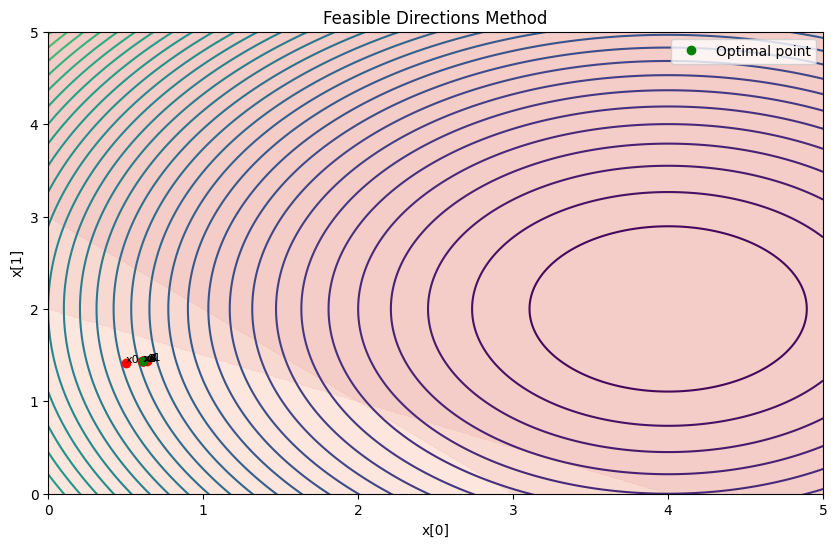

In [73]:
x0 = [1/2, 17/12]
x_star, history, alphas, ps = feasible_directions(x0)
visualize(history, alphas, ps)

## #2.

In [60]:
from sympy import symbols, sympify, diff, Eq, solve
from scipy.optimize import linprog, minimize_scalar, minimize
import numpy as np
import matplotlib.pyplot as plt

In [61]:
def run_iteration(target, x_array, limitations, subs, error):
    try:
        # Step 1
        nabla_f_res = [diff(target, x).subs(subs) for x in x_array]
        limitations_res = [limit.subs(subs) for limit in limitations]
        print(f"Gradient vector: ∇f(x)={nabla_f_res}")

        # Step 2
        limitations_indexes = []
        for i, limit_res in enumerate(limitations_res):
            print(f'\tg{i}(x)={limit_res}')
            if abs(limit_res) <= error:
                limitations_indexes.append(i)
        print(f"Limitation indexes: {limitations_indexes}")

        # Step 3
        if len(limitations_indexes) == 0:
            # Step 5
            s_k = nabla_f_res
            omega_k = sum(k ** 2 for k in nabla_f_res) ** (1 / 2)
        else:
            # Step 4
            omega = symbols('omg')
            s = symbols(' '.join([f's{i + 1}' for i in range(len(x_array))]))

            # target for inner
            c = [float(-omega.coeff(omega))] + [0.0] * len(s)  # -omega because linprog minimizes

            nabla_f = [diff(target, x) for x in x_array]
            extra_limit_expr = -sum(nabla_i * s_i for nabla_i, s_i in zip(nabla_f, s)) + omega
            limitations_inner = [extra_limit_expr]
            for index in limitations_indexes:
                nabla_g = [diff(limitations[index], x) for x in x_array]
                limitations_inner.append(
                    limitations[index] + sum(nabla_i * s_i for nabla_i, s_i in zip(nabla_g, s)) + omega)
            limitations_inner = list(map(lambda x: x.subs(subs), limitations_inner))

            # left part of limitations
            A = [
                [float(expr.coeff(x)) for x in [omega] + list(s)]
                for expr in limitations_inner
            ]
            b = [0.0] * len(limitations_inner)

            # Решение задачи линейного программирования
            result = linprog(c, A_ub=A, b_ub=b,
                             bounds=[(float('-inf'), None)] + [(-1, 1) for _ in range(len(c) - 1)])
            # print(f'Left part inner: {A}')
            # print(f'Right part inner: {b}')

            omega_k = result.x[0]
            s_k = result.x[1:]

        print(f"\tσk: {omega_k}")
        print(f"\tSk: {s_k}")
        # Step 6
        if abs(omega_k) < error:
            print('Found result!')
            return True, subs
        prev = target.subs(subs)

        # Step 7
        # Step 7.1.
        beta = symbols('beta')
        betas_l = []
        for limit in limitations:
            equation = Eq(limit.subs([(sub[0], sub[1] + beta * s_k[i]) for i, sub in enumerate(subs)]), 0)
            solution = list(map(float, solve(equation, beta)))
            betas_l.extend(filter(lambda x: x > 0, solution))
        beta_star = min(betas_l)
        print(f"\tBeta*: {beta_star}")

        # Step 7.2

        def objective_function(beta):
            return -float(target.subs([(sub[0], sub[1] + beta * s_k[i]) for i, sub in enumerate(subs)]))

        # Find the maximum value and the corresponding x
        result = minimize_scalar(objective_function, bounds=(0.0, beta_star), method='bounded')

        subs = [(sub[0], sub[1] + result.x * s_k[i]) for i, sub in enumerate(subs)]
        print(f'Current: {subs}')

        return False, []
    except BaseException as e:
        print(f"Unexpected error: {e}")
        return True, None

In [ ]:
for i in range(1000):
    feedback, result = run_iteration(k)
    print(result)